Before we even start, we should be give an introduction of CNN 

In [19]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm

In [20]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

In [28]:
def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """
    
    datasets = [r'C:\Users\ziyan\OneDrive\NTU BCG Y1S2 2022\SC1015 Intro to DSAI\SC1015 project\seg_train', r"C:\Users\ziyan\OneDrive\NTU BCG Y1S2 2022\SC1015 Intro to DSAI\SC1015 project\seg_test"]
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [30]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading C:\Users\ziyan\OneDrive\NTU BCG Y1S2 2022\SC1015 Intro to DSAI\SC1015 project\seg_train


100%|██████████| 2382/2382 [00:02<00:00, 1023.89it/s]


Loading C:\Users\ziyan\OneDrive\NTU BCG Y1S2 2022\SC1015 Intro to DSAI\SC1015 project\seg_test


100%|██████████| 501/501 [00:00<00:00, 826.22it/s]


In [31]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)


# Let's explore the dataset
##  We can ask ourselves:

- How many training and testing examples do we have ?


- What is the size of the images ?


- What is the proportion of each observed category ?

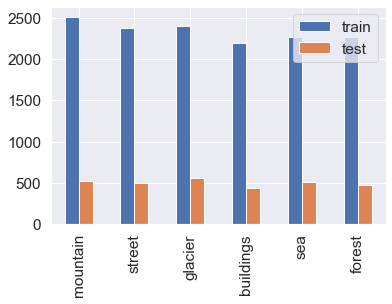

In [32]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

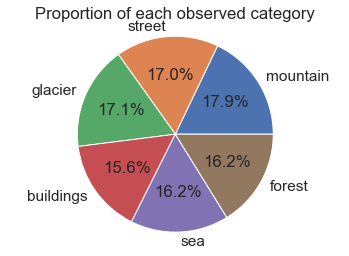

In [33]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

# Good practice: scale the data


In [34]:
#To reduce this we can normalize the values to range from 0 to 1. In this way, the numbers will be small and the computation becomes easier and faster. As the pixel values range from 0 to 256, apart from 0 the range is 255. So dividing all the values by 255 will convert it to range from 0 to 1
train_images = train_images / 255.0 
test_images = test_images / 255.0

# Visualize the data
We can display a random image from the training set.

In [35]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

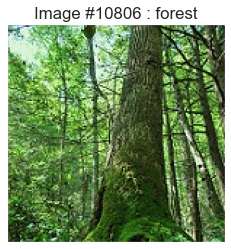

In [36]:
display_random_image(class_names, train_images, train_labels)


We can also display the first 25 images from the training set directly with a loop to get a better view

In [37]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

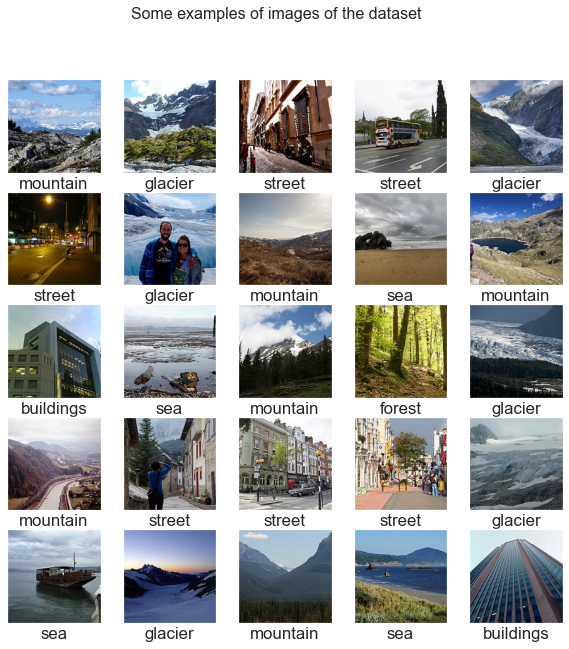

In [38]:
display_examples(class_names, train_images, train_labels)


# Beginner: Simple Model Creation
(for this we should set this as our base case for the CNN model)
Steps are:

- Build the model,
- Compile the model,
- Train / fit the data to the model,
- Evaluate the model on the testing set,
- Carry out an error analysis of our model.


We can build an easy model composed of different layers such as:


- Conv2D: (32 filters of size 3 by 3) The features will be "extracted" from the image.
- MaxPooling2D: The images get half sized.
- Flatten: Transforms the format of the images from a 2d-array to a 1d-array of 150 150 3 pixel values.
- Relu : given a value x, returns max(x, 0).
- Softmax: 6 neurons, probability that the image belongs to one of the classes.

In [39]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

# Maybe here can add picture of what our base model will look like

In [40]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [41]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20
88/88 [==============================] - 118s 1s/step - loss: 1.1336 - accuracy: 0.5630 - val_loss: 0.8950 - val_accuracy: 0.6722
Epoch 2/20
88/88 [==============================] - 111s 1s/step - loss: 0.7561 - accuracy: 0.7224 - val_loss: 0.7437 - val_accuracy: 0.7150
Epoch 3/20
88/88 [==============================] - 107s 1s/step - loss: 0.5759 - accuracy: 0.7927 - val_loss: 0.6615 - val_accuracy: 0.7670
Epoch 4/20
88/88 [==============================] - 104s 1s/step - loss: 0.4424 - accuracy: 0.8457 - val_loss: 0.7472 - val_accuracy: 0.7428
Epoch 5/20
88/88 [==============================] - 113s 1s/step - loss: 0.3251 - accuracy: 0.8945 - val_loss: 0.6787 - val_accuracy: 0.7784
Epoch 6/20
88/88 [==============================] - 111s 1s/step - loss: 0.2340 - accuracy: 0.9250 - val_loss: 0.7592 - val_accuracy: 0.7667
Epoch 7/20
88/88 [==============================] - 105s 1s/step - loss: 0.1566 - accuracy: 0.9546 - val_loss: 0.7650 - val_accuracy: 0.7777
Epoch 8/20
88

In [56]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

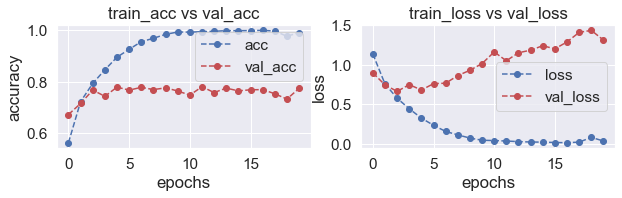

In [57]:
plot_accuracy_loss(history)


In [58]:
test_loss = model.evaluate(test_images, test_labels)


94/94 [==============================] - 7s 73ms/step - loss: 1.3067 - accuracy: 0.7650


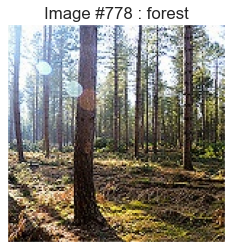

In [59]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, test_images, pred_labels)

# Error analysis


We can try to understand on which kind of images the classifier has trouble.

In [60]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)

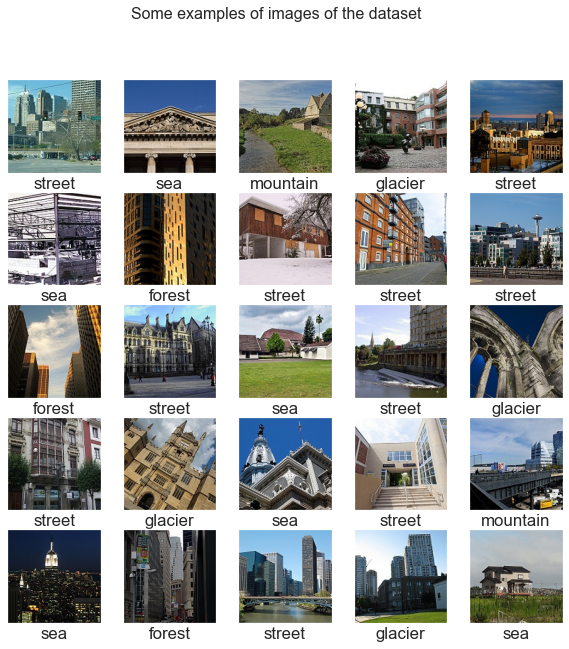

In [61]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

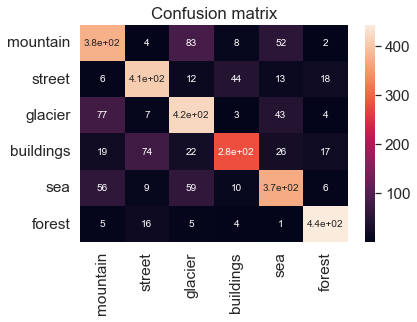

In [62]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

## Conclusion: The classifier has trouble with 2 kinds of images.


It has trouble with street and buildings. Well, it can be understandable as as there are buildings in the street. It has also trouble with sea, glacier and moutain as well. It is hard for me to fully distinguish them. However, it can detects forest very accurately!